In [143]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
from glob import glob
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [144]:
# run params
section = 'vae'
run_id = '0001'
data_name = 'faces'
RUN_FOLDER = 'run/{}/'.format(section)
RUN_FOLDER += '_'.join([run_id, data_name])


DATA_FOLDER = './data/celeb/'
IMAGE_FOLDER = './data/celeb/img_align_celeba/'

In [145]:
att = pd.read_csv(os.path.join(DATA_FOLDER, 'list_attr_celeba.csv'))
att.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [146]:
NUM_CLASSES = 10
BATCH_SIZE = 32
transform = transforms.Compose([   
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)


class SimpleDataset(Dataset):
    def __init__(self, filenames, transform):
        self.filenames = filenames
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img = Image.open(self.filenames[idx])
        if self.transform:
            img = self.transform(img)
        return img

dataset = SimpleDataset(filenames, transform)
dataloader = DataLoader(dataset, BATCH_SIZE)

In [147]:
dataset = SimpleDataset(filenames, transform)
dataloader = DataLoader(dataset, BATCH_SIZE)
z_dim = 200
device = 'cpu'

In [148]:
class Encoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 2)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout()

        self.conv2 = nn.Conv2d(32, 64, 3, 2)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout()

        self.conv3 = nn.Conv2d(64, 64, 3, 2)
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout()

        self.conv4 = nn.Conv2d(64, 64, 3, 2)
        self.bn4 = nn.BatchNorm2d(64)
        self.dropout4 = nn.Dropout()

        self.flatten = nn.Flatten()
        self.mu = nn.Linear(4096, z_dim)

        self.log_var = nn.Linear(4096, z_dim)

    def forward(self, x):
        x = F.pad(self.conv1(x), (1,0,1,0))
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = self.dropout1(x)

        x = F.pad(self.conv2(x), (1,0,1,0))
        x = self.bn2(x)
        x = F.leaky_relu(x)
        x = self.dropout2(x)

        x = F.pad(self.conv3(x), (1,0,1,0))
        x = self.bn3(x)
        x = F.leaky_relu(x)
        x = self.dropout3(x)

        x = F.pad(self.conv4(x), (1,0,1,0))
        x = self.bn4(x)
        x = F.leaky_relu(x)
        x = self.dropout4(x)

        x = self.flatten(x)

        mu, log_var = self.mu(x), self.log_var(x)

        def sampling(args):
            mu, log_var = args
            epsilon = torch.normal(0., 1., size=mu.shape).to(device)
            return mu + torch.exp(log_var / 2) * epsilon

        x = sampling([mu, log_var])

        return x, mu, log_var


In [149]:
class Decoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.linear1 = nn.Linear(z_dim, 64*6*6)

        self.convT1 = nn.ConvTranspose2d(64, 64, 3, 2, 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout()

        self.convT2 = nn.ConvTranspose2d(64, 64, 3, 2, 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout()

        self.convT3 = nn.ConvTranspose2d(64, 32, 3, 2, 1)
        self.bn3 = nn.BatchNorm2d(32)
        self.dropout3 = nn.Dropout()

        self.convT4 = nn.ConvTranspose2d(32, 3, 3, 2)

    def forward(self, x):
        x = self.linear1(x)
        x = x.reshape(-1, 64, 6, 6)

        x = F.pad(self.convT1(x), (2,1,2,1))      
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = self.dropout1(x)

        x = F.pad(self.convT2(x), (2,1,2,1))      
        x = self.bn2(x)
        x = F.leaky_relu(x)
        x = self.dropout2(x)

        x = F.pad(self.convT3(x), (2,1,2,1))      
        x = self.bn3(x)
        x = F.leaky_relu(x)
        x = self.dropout3(x)

        x = F.pad(self.convT4(x), (2,1,2,1)) 
        
        return torch.sigmoid(x)


In [150]:
class AutoEncoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = Encoder().to(device)
        self.decoder = Decoder().to(device)
    def forward(self, x):
        t, mu, log_var = self.encoder(x)
        x = self.decoder(t)
        return x, t, mu, log_var

In [151]:
model = torch.load(RUN_FOLDER + '/weights/weight.pt').cpu()

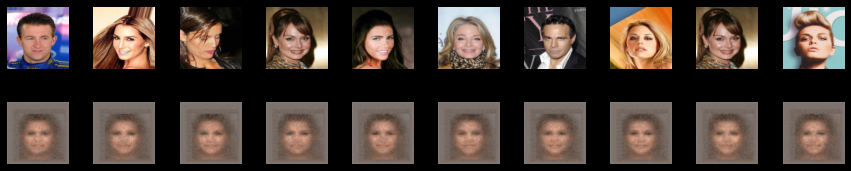

In [152]:
with torch.no_grad():
    transform1 = transforms.ToPILImage()

    n_to_show = 10
    images = next(iter(dataloader))

    example_idx = np.random.choice(range(len(images)), n_to_show)
    example_images = images[example_idx]

    z_points, _, _ = model.encoder(example_images)

    reconst_images = model.decoder(z_points)

    fig = plt.figure(figsize=(15, 3))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i in range(n_to_show):
        img = transform1(example_images[i].squeeze())
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')        
        sub.imshow(img)

    for i in range(n_to_show):
        img = transform1(reconst_images[i].squeeze())
        sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
        sub.axis('off')
        sub.imshow(img)


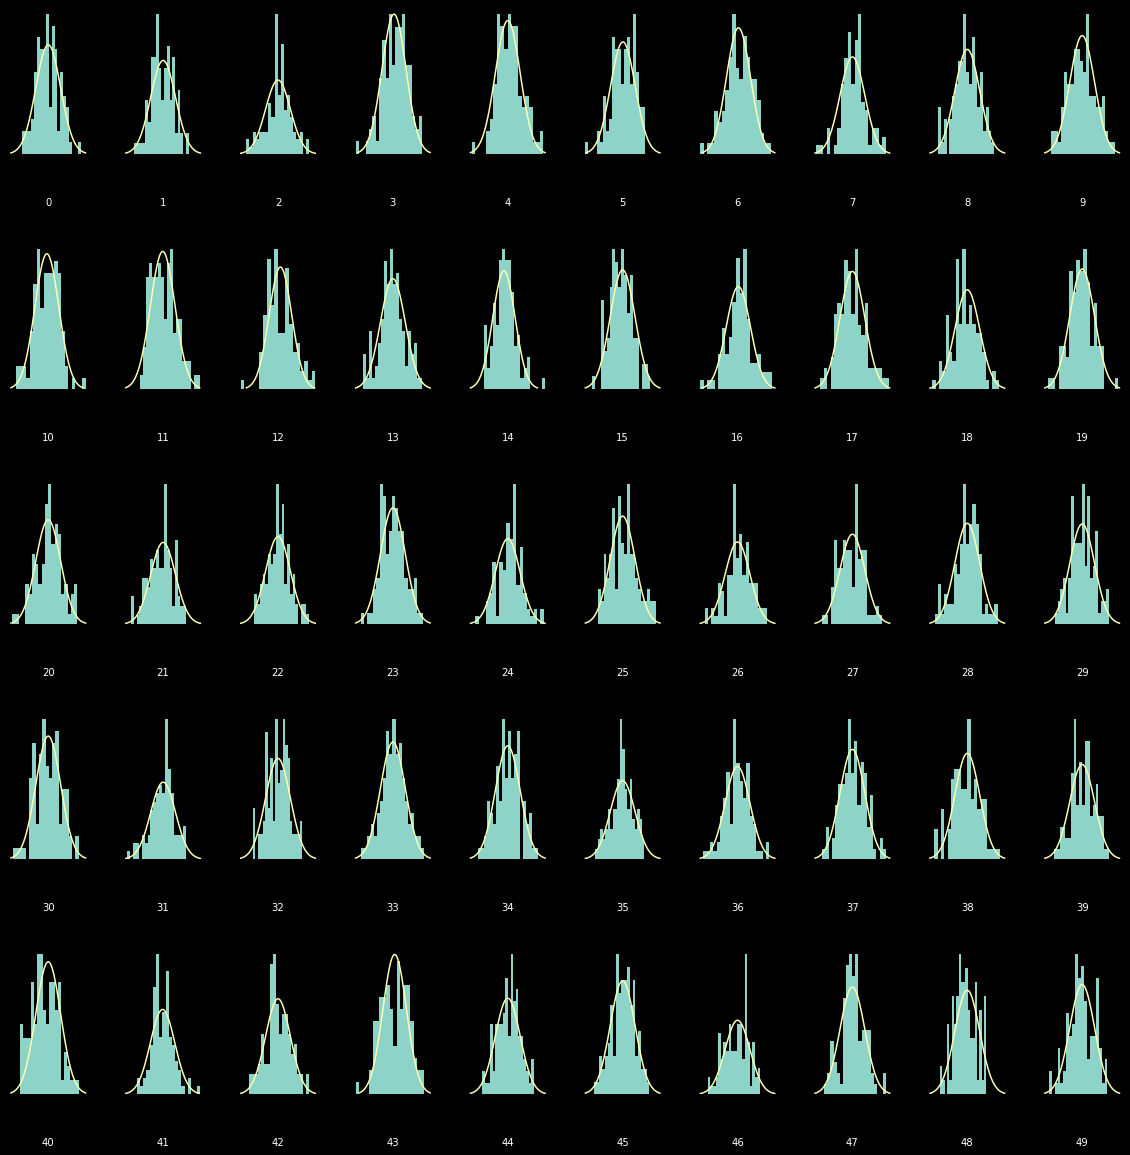

In [153]:
with torch.no_grad():
    dataloader = DataLoader(dataset, 100)
    inputs = next(iter(dataloader))
    z_test, _, _ =model.encoder(inputs)

    z_test = z_test.numpy()

    x = np.linspace(-3, 3, 100)

    fig = plt.figure(figsize=(20, 20))
    fig.subplots_adjust(hspace=0.6, wspace=0.4)

    for i in range(50):
        ax = fig.add_subplot(5, 10, i+1)
        ax.hist(z_test[:,i], density=True, bins = 20)
        ax.axis('off')
        ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
        ax.plot(x,norm.pdf(x))

    plt.show()

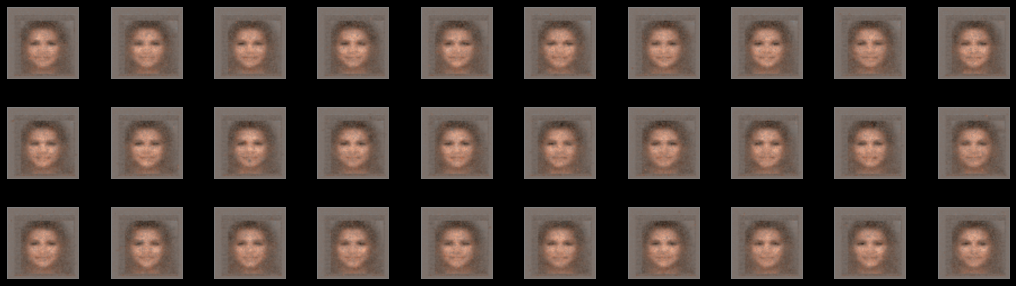

In [154]:
with torch.no_grad():
    transform1 = transforms.ToPILImage()
    n_to_show = 30
    znew = np.random.normal(size = (n_to_show,200))
    znew = np.array(znew, dtype=np.float32)

    reconst = model.decoder(torch.from_numpy(znew))

    fig = plt.figure(figsize=(18, 5))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for i in range(n_to_show):
        ax = fig.add_subplot(3, 10, i+1)
        img = transform1(reconst[i, :,:,:])
        ax.imshow(img)
        ax.axis('off')

    plt.show()

In [155]:
class SimpleDataset(Dataset):
    def __init__(self, dataframe, transform):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img = Image.open(f"{DATA_FOLDER}/img_align_celeba/{self.dataframe.iloc[idx][0]}")
        label = torch.tensor(self.dataframe.iloc[idx][1:])
        if self.transform:
            img = self.transform(img)
        return img, label
att = pd.read_csv(os.path.join(DATA_FOLDER, 'list_attr_celeba.csv'))
dataset = SimpleDataset(att, transform)
dataloader = DataLoader(dataset, BATCH_SIZE)

In [156]:
torch.tensor(att.iloc[0][1:]).shape

torch.Size([40])

In [157]:
next(iter(dataloader))[1].numpy()[:,1]

array([ 1, -1, -1, -1,  1,  1, -1,  1,  1, -1, -1, -1, -1,  1, -1, -1, -1,
        1,  1, -1, -1,  1, -1,  1, -1, -1,  1, -1,  1, -1, -1, -1],
      dtype=int64)

In [158]:
def get_vector_from_label(label, batch_size):
    column_arr = np.array(att.columns)[1:]
    index = np.where(column_arr == label)

    dataloader = DataLoader(dataset, batch_size)

    origin = np.zeros(shape = 200, dtype = 'float32')
    current_sum_POS = np.zeros(shape = 200, dtype = 'float32')
    current_n_POS = 0
    current_mean_POS = np.zeros(shape = 200, dtype = 'float32')

    current_sum_NEG = np.zeros(shape = 200, dtype = 'float32')
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape = 200, dtype = 'float32')

    current_vector = np.zeros(shape = 200, dtype = 'float32')
    current_dist = 0

    print('label: ' + label)
    print('images : POS move : NEG move :distance : 𝛥 distance')
    while(current_n_POS < 10000):

        batch = next(iter(dataloader))
        im = batch[0].numpy()
        im = np.array(im, dtype=np.float32)

        attribute = batch[1].numpy()[:,index].reshape(batch_size)

        with torch.no_grad():
            z, _, _ = model.encoder(torch.tensor(im))
        z = z.numpy()
        # print(z.shape, attrib/ute.shape)

        z_POS = z[attribute==1]
        z_NEG = z[attribute==-1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis = 0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS-current_mean_POS)

        if len(z_NEG) > 0: 
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis = 0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG-current_mean_NEG)

        current_vector = new_mean_POS-new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist


        print(str(current_n_POS)
              + '    : ' + str(np.round(movement_POS,3))
              + '    : ' + str(np.round(movement_NEG,3))
              + '    : ' + str(np.round(new_dist,3))
              + '    : ' + str(np.round(dist_change,3))
             )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print('Found the ' + label + ' vector')
            break

    return current_vector   


In [159]:
BATCH_SIZE = 500
attractive_vec = get_vector_from_label('Attractive', BATCH_SIZE)
mouth_open_vec = get_vector_from_label('Mouth_Slightly_Open', BATCH_SIZE)
smiling_vec = get_vector_from_label('Smiling', BATCH_SIZE)
lipstick_vec = get_vector_from_label('Wearing_Lipstick', BATCH_SIZE)
young_vec = get_vector_from_label('High_Cheekbones', BATCH_SIZE)
male_vec = get_vector_from_label('Male', BATCH_SIZE)

label: Attractive
images : POS move : NEG move :distance : 𝛥 distance
262    : 0.835    : 0.894    : 1.18    : 1.18
524    : 0.627    : 0.605    : 0.89    : -0.29
786    : 0.338    : 0.419    : 0.698    : -0.192
1048    : 0.235    : 0.276    : 0.59    : -0.108
1310    : 0.212    : 0.198    : 0.556    : -0.034
1572    : 0.165    : 0.155    : 0.517    : -0.039
1834    : 0.125    : 0.145    : 0.459    : -0.058
2096    : 0.123    : 0.127    : 0.422    : -0.037
2358    : 0.1    : 0.101    : 0.41    : -0.012
2620    : 0.095    : 0.091    : 0.393    : -0.017
2882    : 0.083    : 0.095    : 0.375    : -0.018
3144    : 0.079    : 0.08    : 0.366    : -0.009
3406    : 0.069    : 0.071    : 0.353    : -0.013
3668    : 0.068    : 0.067    : 0.341    : -0.012
3930    : 0.061    : 0.06    : 0.328    : -0.013
4192    : 0.051    : 0.058    : 0.321    : -0.007
4454    : 0.051    : 0.055    : 0.312    : -0.009
4716    : 0.05    : 0.053    : 0.303    : -0.009
4978    : 0.046    : 0.043    : 0.295    : -0

In [160]:
eyeglasses_vec = get_vector_from_label('Eyeglasses', BATCH_SIZE)

label: Eyeglasses
images : POS move : NEG move :distance : 𝛥 distance
31    : 2.616    : 0.666    : 2.624    : 2.624
62    : 1.743    : 0.454    : 1.861    : -0.763
93    : 1.038    : 0.275    : 1.539    : -0.322
124    : 0.713    : 0.181    : 1.264    : -0.276
155    : 0.616    : 0.147    : 1.105    : -0.159
186    : 0.468    : 0.131    : 0.99    : -0.114
217    : 0.39    : 0.098    : 0.913    : -0.077
248    : 0.34    : 0.093    : 0.846    : -0.067
279    : 0.311    : 0.078    : 0.804    : -0.043
310    : 0.253    : 0.065    : 0.805    : 0.001
341    : 0.229    : 0.062    : 0.766    : -0.039
372    : 0.209    : 0.054    : 0.74    : -0.026
403    : 0.209    : 0.051    : 0.695    : -0.045
434    : 0.178    : 0.05    : 0.665    : -0.03
465    : 0.181    : 0.046    : 0.656    : -0.01
496    : 0.159    : 0.043    : 0.651    : -0.004
527    : 0.147    : 0.043    : 0.636    : -0.015
558    : 0.142    : 0.042    : 0.631    : -0.005
589    : 0.14    : 0.037    : 0.608    : -0.023
620    : 0.1

In [161]:
blonde_vec = get_vector_from_label('Blond_Hair', BATCH_SIZE)

label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
71    : 1.622    : 0.705    : 1.814    : 1.814
142    : 1.184    : 0.5    : 1.303    : -0.511
213    : 0.722    : 0.259    : 1.094    : -0.208
284    : 0.461    : 0.178    : 0.986    : -0.108
355    : 0.369    : 0.161    : 0.889    : -0.097
426    : 0.306    : 0.123    : 0.803    : -0.086
497    : 0.281    : 0.112    : 0.75    : -0.053
568    : 0.238    : 0.098    : 0.678    : -0.071
639    : 0.189    : 0.083    : 0.651    : -0.027
710    : 0.195    : 0.07    : 0.625    : -0.026
781    : 0.157    : 0.065    : 0.61    : -0.016
852    : 0.158    : 0.062    : 0.587    : -0.023
923    : 0.132    : 0.054    : 0.559    : -0.028
994    : 0.12    : 0.052    : 0.519    : -0.04
1065    : 0.115    : 0.049    : 0.507    : -0.012
1136    : 0.119    : 0.041    : 0.473    : -0.034
1207    : 0.101    : 0.044    : 0.449    : -0.025
1278    : 0.095    : 0.04    : 0.444    : -0.004
1349    : 0.089    : 0.034    : 0.433    : -0.011
1420

In [162]:
# batch = next(iter(dataloader))
# im = batch[0].numpy()
# im = np.array(im, dtype=np.float32)

# attribute = batch[1].numpy()[:,index].reshape(batch_size)

# with torch.no_grad():
#     z, _, _ = model.encoder(torch.tensor(im))
# z = z.numpy()
# # print(z.shape, attrib/ute.shape)

In [163]:
def add_vector_to_images(feature_vec):
    with torch.no_grad():
        transform1 = transforms.ToPILImage()
        n_to_show = 5
        factors = [-4,-3,-2,-1,0,1,2,3,4]
        dataloader = DataLoader(dataset, 50)
        example_batch = next(iter(dataloader))
        example_images = example_batch[0]
        example_labels = example_batch[1]

        z_points, _, _ = model.encoder(example_images)

        fig = plt.figure(figsize=(18, 10))

        counter = 1

        for i in range(n_to_show):

            img = transform1(example_images[i].squeeze())
            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis('off')        
            sub.imshow(img)

            counter += 1

            for factor in factors:

                changed_z_point = z_points[i] + feature_vec * factor
                # print(changed_z_point)
                # changed_z_point = torch.tensor([changed_z_point], dtype=torch.float32)

                changed_image = model.decoder(changed_z_point)

                img = transform1(changed_image.squeeze())
                sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
                sub.axis('off')
                sub.imshow(img)

                counter += 1

        plt.show()


Eyeglasses Vector


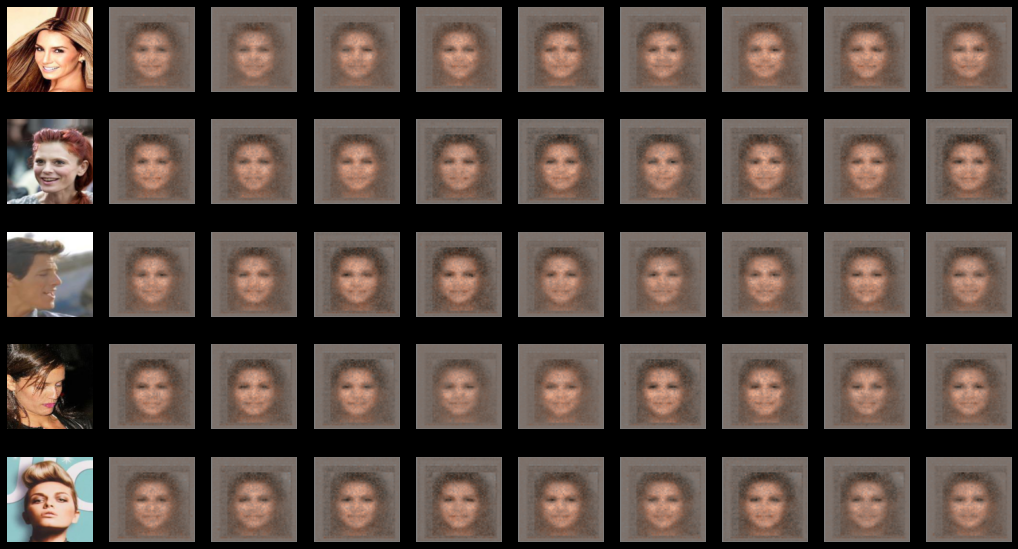

In [164]:
# print('Attractive Vector')
# add_vector_to_images(attractive_vec)

# print('Mouth Open Vector')
# add_vector_to_images(mouth_open_vec)

# print('Smiling Vector')
# add_vector_to_images(smiling_vec)

# print('Lipstick Vector')
# add_vector_to_images(lipstick_vec)

# print('Young Vector')
# add_vector_to_images(young_vec)

# print('Male Vector')
# add_vector_to_images(male_vec)

print('Eyeglasses Vector')
add_vector_to_images(eyeglasses_vec)

# print('Blond Vector')
# add_vector_to_images(blonde_vec)

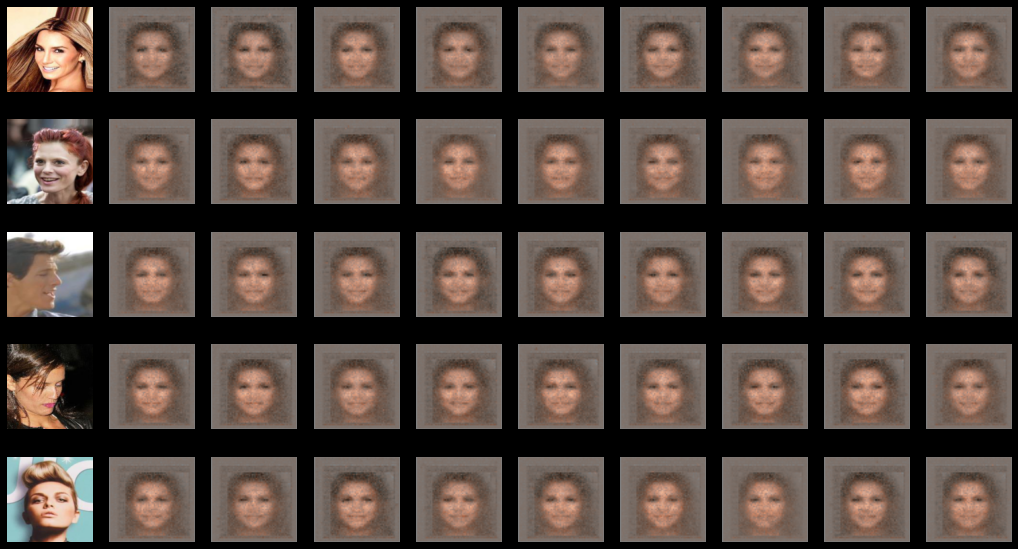

In [165]:
add_vector_to_images(male_vec)

In [166]:

def morph_faces(start_image_file, end_image_file):
    with torch.no_grad():
        transform1 = transforms.ToPILImage()

        factors = np.arange(0,1,0.1)

        att_specific = att[att['image_id'].isin([start_image_file, end_image_file])]
        att_specific = att_specific.reset_index()
        att_specific.pop('index')
        dataloader = DataLoader(SimpleDataset(att_specific, transform), 2)

        example_batch = next(iter(dataloader))
        example_images = example_batch[0]
        example_labels = example_batch[1]

        z_points, _, _ = model.encoder(example_images)


        fig = plt.figure(figsize=(18, 8))

        counter = 1

        img = example_images[0].squeeze()
        sub = fig.add_subplot(1, len(factors)+2, counter)
        sub.axis('off')        
        sub.imshow(transform1(img))

        counter+=1


        for factor in factors:

            changed_z_point = z_points[0] * (1-factor) + z_points[1]  * factor
            changed_image = model.decoder(changed_z_point)

            img = changed_image.squeeze()
            sub = fig.add_subplot(1, len(factors)+2, counter)
            sub.axis('off')
            sub.imshow(transform1(img))

            counter += 1

        img = example_images[1].squeeze()
        sub = fig.add_subplot(1, len(factors)+2, counter)
        sub.axis('off')        
        sub.imshow(transform1(img))


        plt.show()

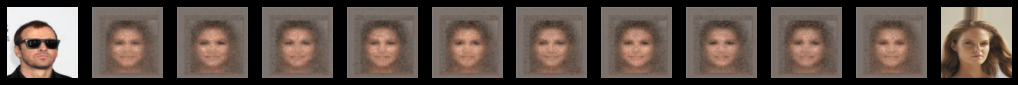

In [167]:
start_image_file = '000238.jpg' 
end_image_file = '000193.jpg' #glasses

morph_faces(start_image_file, end_image_file)

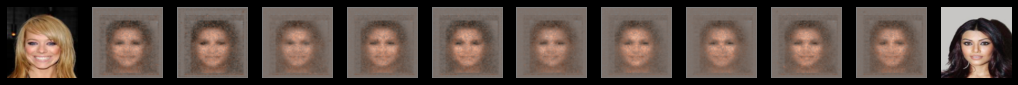

In [168]:
start_image_file = '000112.jpg'
end_image_file = '000258.jpg'

morph_faces(start_image_file, end_image_file)

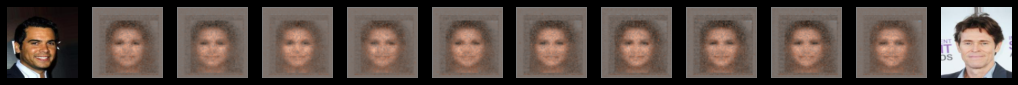

In [169]:
start_image_file = '000230.jpg'
end_image_file = '000712.jpg'

morph_faces(start_image_file, end_image_file)